<a href="https://colab.research.google.com/github/adalbertii/Modele-klasyfikacyjne/blob/main/CNN_sentiment_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd

path = '/content/drive/MyDrive/dane/sentiment'

filepath_dict = {'yelp': '/content/drive/MyDrive/dane/sentiment/yelp_labelled.txt',
                 'amazon': '/content/drive/MyDrive/dane/sentiment/amazon_cells_labelled.txt',
                 'imdb': '/content/drive/MyDrive/dane/sentiment/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
   df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
   # Add another column filled with the source name
   df['source'] = source
   df_list.append(df)
   df = pd.concat(df_list)

print(df.head())

                                            sentence  label source
0                           Wow... Loved this place.      1   yelp
1                                 Crust is not good.      0   yelp
2          Not tasty and the texture was just nasty.      0   yelp
3  Stopped by during the late May bank holiday of...      1   yelp
4  The selection on the menu was great and so wer...      1   yelp


In [7]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [6]:
df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values



In [8]:
sentences_train,sentences_test,y_train,y_test = train_test_split(sentences, y,
                                                                 test_size=0.25,
                                                                random_state=1000)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [9]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [12]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('/content/drive/MyDrive/dane/sentiment/glove.6B.50d.txt',
                                            tokenizer.word_index,
                                            embedding_dim)


In [14]:
from keras.models import Sequential
from keras import layers


In [15]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          174700    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 240129 (938.00 KB)
Trainable params: 240129 (938.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [17]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/10
75/75 [==============================] - 3s 29ms/step - loss: 0.6850 - accuracy: 0.5933 - val_loss: 0.6672 - val_accuracy: 0.6640
Epoch 2/10
75/75 [==============================] - 2s 24ms/step - loss: 0.5076 - accuracy: 0.8400 - val_loss: 0.4811 - val_accuracy: 0.7480
Epoch 3/10
75/75 [==============================] - 1s 14ms/step - loss: 0.1659 - accuracy: 0.9560 - val_loss: 0.4928 - val_accuracy: 0.7720
Epoch 4/10
75/75 [==============================] - 1s 13ms/step - loss: 0.0393 - accuracy: 0.9947 - val_loss: 0.5451 - val_accuracy: 0.7840
Epoch 5/10
75/75 [==============================] - 1s 13ms/step - loss: 0.0128 - accuracy: 0.9987 - val_loss: 0.5468 - val_accuracy: 0.8000
Epoch 6/10
75/75 [==============================] - 1s 14ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.5772 - val_accuracy: 0.8080
Epoch 7/10
75/75 [==============================] - 1s 14ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.6017 - val_accuracy: 0.8040
Epoch 8/10
75

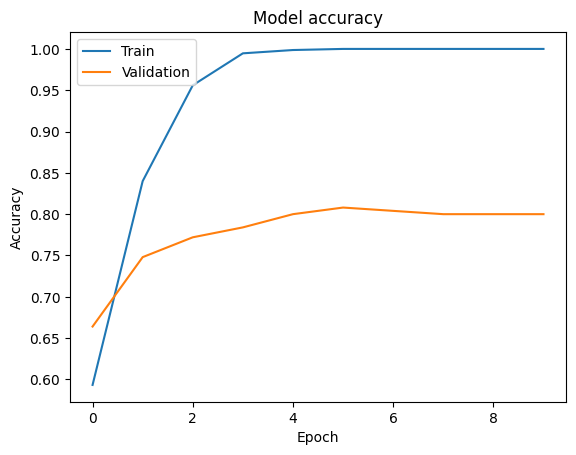

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()